In [3]:
import numpy as np
import pandas as pd
import scanpy as sc

Dataset: GSE118487, A single-cell RNA-seq analysis of molecular characterization of hypothalamic progenitor

cells Object: Homo sapiens

Sample: GSM3330882 GW10-Hy, human embryonic hypothalamic tissues

Processing steps: dissection, papain-based tissue dissociation into single-cell suspension, partitioning into Gel
Bead-In-EMulsions (GEMs) by 10x GemCode™, cDNA libraries preparation with Single Cell 3’ Reagent
Kits, sequencing.

Platform: Illumina HiSeq 4000 (Homo sapiens)

#### First, we loaded the 10x data into an AnnData object

Initially, we have 7148 cells and 32738 genes present.

In [4]:
adata = sc.read_10x_mtx(
    '/home/alevtina/Downloads/gse/1',
    var_names='gene_symbols',
    cache=True)    
adata

AnnData object with n_obs × n_vars = 7148 × 32738
    var: 'gene_ids'

#### Then, performed basic filtering (filtered out genes which were found in less than 10 cells, as well as cells which expressed less than 20 genes)

This left us with 7148 cells and 15105 genes

In [5]:
sc.pp.filter_cells(adata, min_genes=20)
sc.pp.filter_genes(adata, min_cells=20)

In [6]:
adata

AnnData object with n_obs × n_vars = 7148 × 15105
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

#### After that, attempted to find dying cells with high percentage of mitochondrial genes expression:

In [8]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=True, inplace=True)

In [9]:
adata.var['mt'].value_counts()

False    15092
True        13
Name: mt, dtype: int64

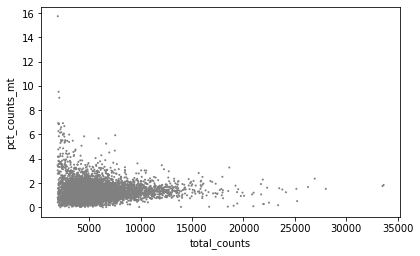

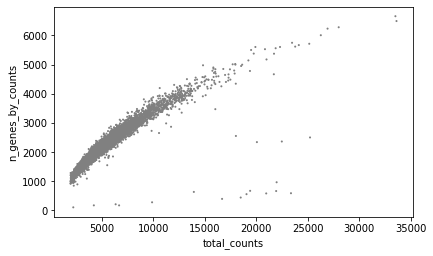

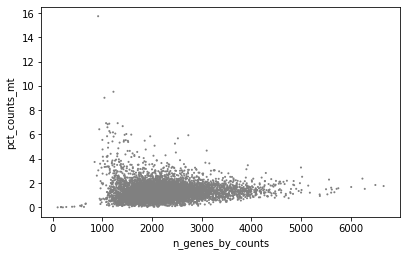

In [10]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color='CST3')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='CST3')
sc.pl.scatter(adata, x='n_genes_by_counts', y='pct_counts_mt', color='CST3')

As we can see, most cells were very much alive. Still, we filtered out some dying ones as well as cells with
very low coverage. 7148-7107=41 cells were filtered out.

In [11]:
adata = adata[adata.obs.n_genes_by_counts > 1000, :].copy()
adata = adata[adata.obs.pct_counts_mt < 6, :].copy()

adata

AnnData object with n_obs × n_vars = 7107 × 15105
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

This was the resulting jointplot:

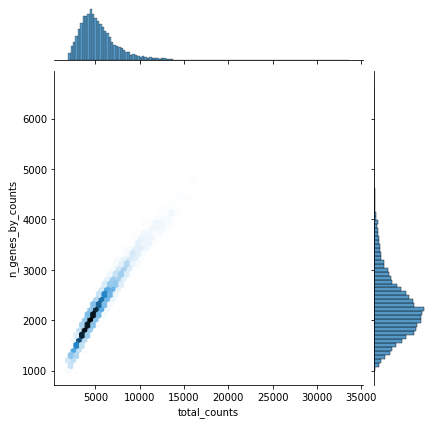

In [12]:
import scanpy as sc
import seaborn as sns

sns.jointplot(
    data=adata.obs,
    x="total_counts",
    y="n_genes_by_counts",
    kind="hex",
    color='CST3'
)

#### Then, we normalized and filtered out the data, comparing the distribution of the top-20 highest expressed genes:

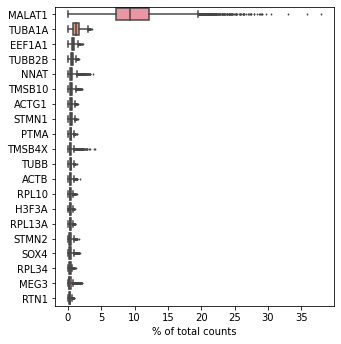

In [13]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [14]:
sc.pp.normalize_total(adata, target_sum=1e4) # Total-count normalize (library-size correct) the data matrix X to 10,000 reads per cell, so that counts become comparable among cells.
sc.pp.log1p(adata) # log-normalization

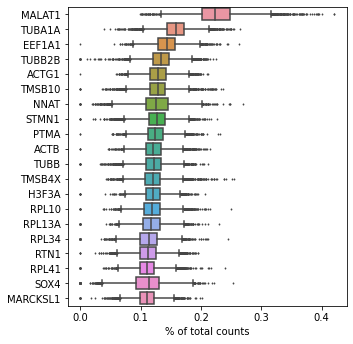

In [15]:
sc.pl.highest_expr_genes(adata, n_top=20, )

Indeed, gene counts look normalized now.

#### Then, we searched for biologically variable genes:

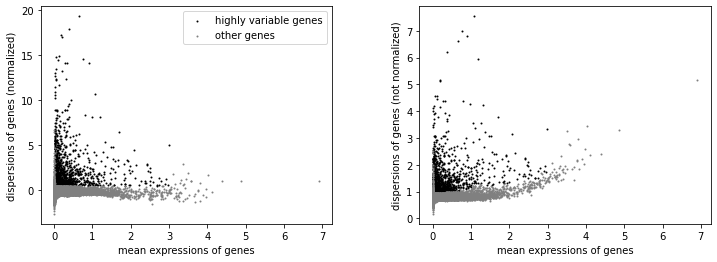

In [16]:
import matplotlib.pyplot as plt
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
gca = sc.pl.highly_variable_genes(adata, show=False, log=False, color='CST3')

In [17]:
adata.var['highly_variable'].value_counts()

False    13829
True      1276
Name: highly_variable, dtype: int64

#### And proceeded with PCA dimensionality reduction

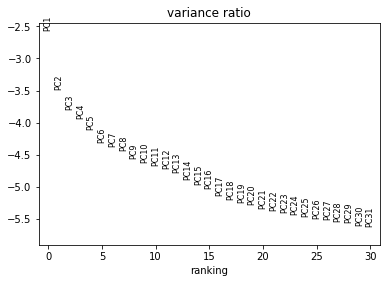

In [18]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

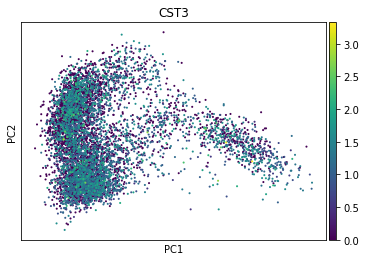

In [19]:
sc.pl.pca(adata, color='CST3')

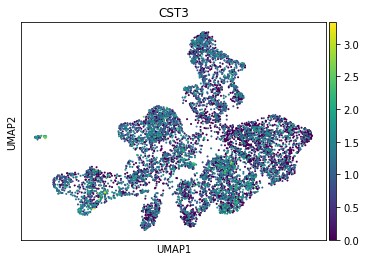

In [24]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=20)
sc.tl.umap(adata)
sc.pl.umap(adata, color='CST3')

# 7. Cell clusters
## How we do it in R
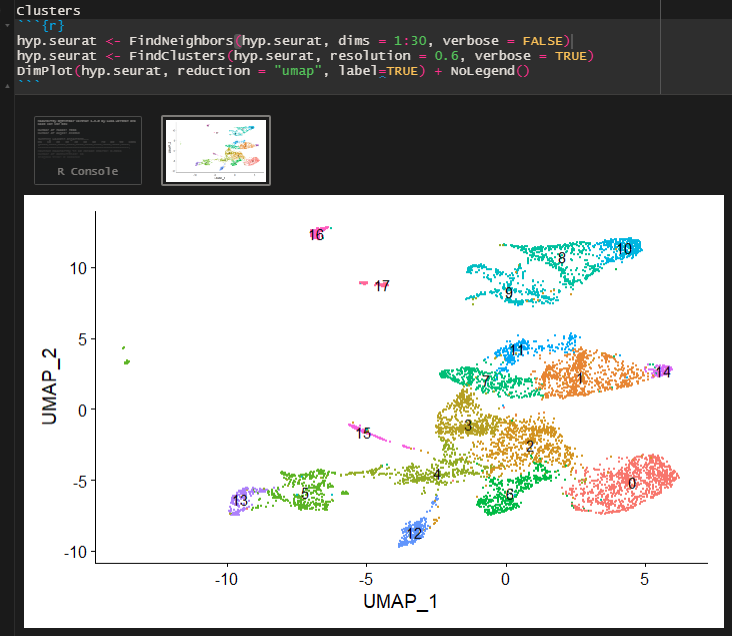
## How we do it in Python


In [ ]:
sc.tl.louvain(adata, resolution=1.2)
sc.pl.umap(adata, color='louvain')

# 8. Visualizing gene expression in clusters
## How we do it in R
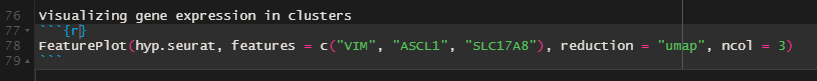
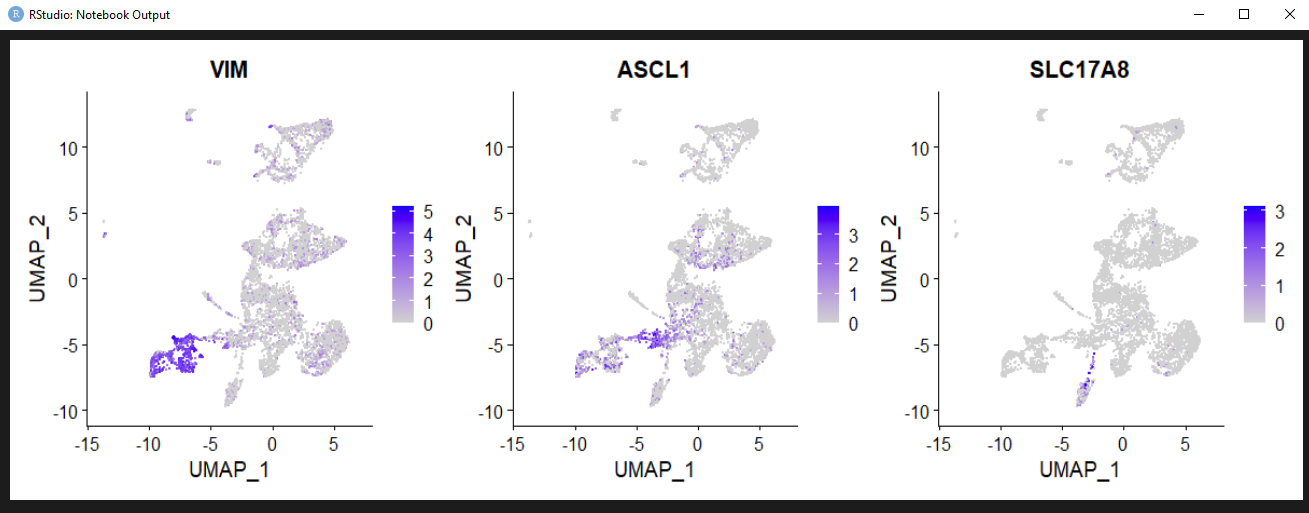
## How we do it in Python

In [ ]:
sc.pl.umap(adata, color=["VIM", "ASCL1", "SLC17A8"])

# 9. Running DGE tests to find cluster biomarkers

## How we do it in R
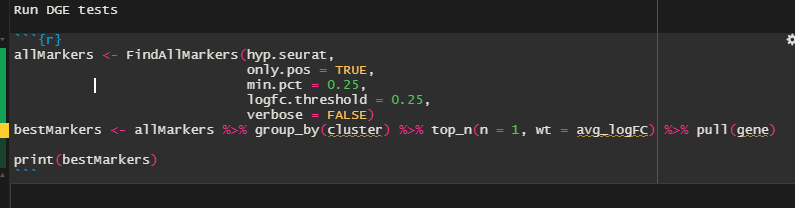

Took infinity to calculate
## How we do it in Python

In [ ]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(1)

In [ ]:
sc.pl.umap(adata, color=["FEZF1", "HES6", "OTP"])

## Another clustering and change size

In [ ]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (10, 10)}):
    sc.tl.leiden(adata, resolution=0.7)
    sc.pl.umap(adata, color='leiden', s=20)

## Extract embeddings

In [ ]:
adata.obsm

In [ ]:
df = pd.DataFrame(adata.obsm['X_pca'])

In [ ]:
df

In [ ]:
adata.X

In [ ]:
adata.var

In [ ]:
adata.obs

In [ ]:
adata.uns